# Lagrane Points Computation using CR3BP

This tutorial illustrates the computation of the five lagrange points (equilibrium solutions) of the **Earth-Moon** system modeled through the Circular Restricted Three Body Problem (CR3BP).

The location of the points are computed with respect to the barycenter of the primiaries in a rotating reference frame.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ostk.physics.environment.object.celestial import Earth, Moon
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.gravitational import Moon as MoonGravitationalModel
from ostk.physics.coordinate import Frame
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.unit import Length
from ostk.physics.unit import Time
from ostk.physics.unit import Derived

### Initialize and compute the mass ratio ($\mu$) and distance between the primaries (l<sup>*</sup>)

For primary 1: Earth (m<sub>1</sub>) and primary 2: Moon (m<sub>2</sub>) :-

1. $\mu = \frac{m_2}{m_1+m_2}$
2. l<sup>*</sup> = absolute average distance between the primaries

In [2]:
# Obtain GM value of p1 and p2
earth_grav_param = EarthGravitationalModel.spherical.gravitational_parameter
p1_grav_param_val = earth_grav_param.in_unit(Derived.Unit.gravitational_parameter(Length.Unit.Meter, Time.Unit.Second))
moon_grav_param = MoonGravitationalModel.spherical.gravitational_parameter
p2_grav_param_val = moon_grav_param.in_unit(Derived.Unit.gravitational_parameter(Length.Unit.Meter, Time.Unit.Second))

# Compute mu
mu = (p2_grav_param_val)/(p1_grav_param_val+p2_grav_param_val)
print(mu)

0.012150583925358626


In [3]:
# Calculate the average distance between p1 and p2 (over a lunar cycle ~ 28 days)
p1 = Earth.default()
p2 = Moon.default()

# Define a common frame
frame = Frame.ITRF()

def get_p1p2_dist_at_epoch(p1, p2, day):

    instant = Instant.J2000() + Duration.days(float(day))

    # Get the position of p1 and p2 in the common frame and time
    p1_position = p1.get_position_in(frame, instant).get_coordinates()
    p2_position = p2.get_position_in(frame, instant).get_coordinates()

    # Calculate the distance between the two positions
    distance = np.linalg.norm(p1_position - p2_position)
    return distance

# Distances over a lunar cycle
distances = [get_p1p2_dist_at_epoch(p1, p2, day) for day in range(28)]

# Average distance in km
lstar = np.average(np.array(distances)/1000.0)
print(lstar)

385393.4224798973


### Location of the primaries with respect to their barycenter

$\bar{x}_{P_1} = (-\mu,0,0)$ 

$\bar{x}_{P_2} = (1-\mu,0,0)$

In [4]:
pos_p1 = np.array([-1 * mu, 0, 0]) * lstar # unit: km, value < radius of the Earth
pos_p2 = np.array([1 - 1 * mu, 0, 0]) * lstar # unit: km
print(f'P1 location wrt barycenter: {pos_p1} km')
print(f'P2 location wrt barycenter: {pos_p2} km')

P1 location wrt barycenter: [-4682.7551241231859 0.0 0.0] km
P2 location wrt barycenter: [380710.66735577409 0.0 0.0] km


### Computation of triangular Lagrange points (L<sub>4</sub> and L<sub>5</sub>)
Triangular Lagrange points form equilateral triangles with the two primaries and are only dependent on the $\mu$ value of the system.

Location w.r.t the barycenter: $\bar{x}_{L_{4,5}} = (\frac{1}{2}-\mu,\pm\frac{\sqrt{3}}{2},0)$

In [5]:
pos_l4 = np.array([0.5 - mu, 3**0.5 / 2, 0])
pos_l5 = np.array([0.5 - mu, -3**0.5 / 2, 0])

### Computation of collinear Lagrange points (L<sub>1</sub>, L<sub>2</sub> and L<sub>3</sub>)
Collinear Lagrange points are the equlibrium solutions of CR3BP EOMS that are computed through the roots of the polynmial derived by subsituting, $y=z=\dot{x}=\dot{y}=\dot{z}=\ddot{x}=\ddot{y}=\ddot{z}=0$, to the EOMs. 

In [6]:
# Store location of the lagrange points w.r.t the barycenter:
lag_loc = np.zeros((5, 3))
# 5th degree polynomial of L1, L2 and L3
f_lib = np.array(
    [
        [1, mu - 3, 3 - 2 * mu, - 1 * mu, 2 * mu, - 1 * mu],
        [1, 3 - mu, 3 - 2 * mu, - 1 * mu, -2 * mu, - 1 * mu],
        [1, 2 + mu, 1 + 2 * mu, mu - 1, 2 * mu - 2, -1 + mu],
    ]
)

def get_real_root(poly):
    roots = np.roots(poly)
    for root in roots:
        if np.isreal(root):
            return np.real(root)

lag_loc[0, 0] = 1 -1 * mu - get_real_root(f_lib[0,:])
lag_loc[1, 0] = 1 -1 * mu + get_real_root(f_lib[1,:])
lag_loc[2, 0] = -1 * mu - get_real_root(f_lib[2,:])

# Store location of L4 and L5 in lag_loc
lag_loc[3,:] = pos_l4
lag_loc[4,:] = pos_l5

# Change units from non-dimensional to km, w.r.t barycenter
lag_loc = lag_loc * lstar
for i in range(1,6):
    print(f"L{i}: {lag_loc[i-1,:]} km")

L1: [322541.58784054      0.              0.        ] km
L2: [445392.30254327      0.              0.        ] km
L3: [-387344.53260508       0.               0.        ] km
L4: [188013.95611583 333760.49431902      0.        ] km
L5: [ 188013.95611583 -333760.49431902       0.        ] km


(-428981.37436249666,
 487029.1443006847,
 -367136.54375092173,
 367136.54375092173)

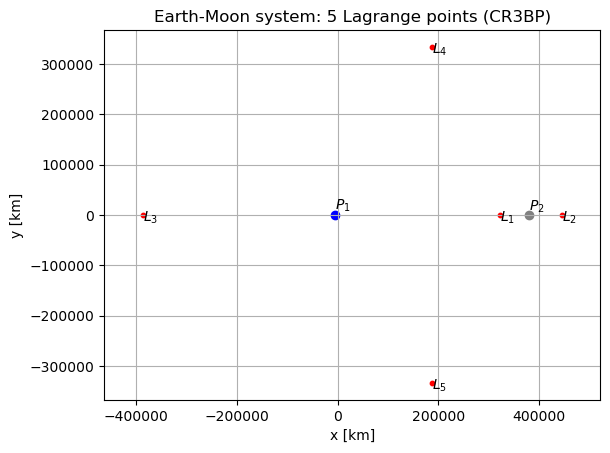

In [7]:
fig = plt.figure()
ax = plt.gca()
plt.scatter(pos_p1[0],0,color='blue')
plt.scatter(pos_p2[0],0,color='grey')
plt.scatter(lag_loc[:,0],lag_loc[:,1],s=10,color='red')
plt.text(pos_p2[0],1e+4/1.2,'$P_2$')
plt.text(pos_p1[0],1e+4,'$P_1$')
for i in range(5):
    plt.text(lag_loc[i,0],lag_loc[i,1]-1e+4*1.2,'$L_'+str(i+1)+'$')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title("Earth-Moon system: 5 Lagrange points (CR3BP)")
plt.grid()
plt.axis("equal")